<a href="https://colab.research.google.com/github/kdemertzis/LNexamples/blob/main/14_OutlierDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Μια μελέτη περίπτωσης ανίχνευσης ακραίων σημείων


Θα δημιουργήσουμε ένα σύνολο δεδομένων  που θα περιέχει μόνο δύο στήλες:
* Όνομα των υπαλλήλων ενός οργανισμού
* Μισθοί αυτών των υπαλλήλων (σε USD) μεταξύ 1000 και 2500 (Μηνιαία)

Για να δημιουργήσουμε τα ονόματα (και να τα κάνουμε να μοιάζουν με τα πραγματικά) θα χρησιμοποιήσουμε μια βιβλιοθήκη Python που ονομάζεται Faker (διαβάστε την τεκμηρίωση [εδώ](https://faker.readthedocs.io/en/latest/index.html)). 
Για τη δημιουργία μισθών, θα χρησιμοποιήσουμε ένα numpy. Μετά θα τα συγχωνεύσουμε σε ένα DataFrame pandas. Θα δημιουργήσουμε αρχεία για 100 υπαλλήλους. Ας ξεκινήσουμε.


In [ ]:
!pip install Faker

     |████████████████████████████████| 1.1MB 11.9MB/s 


In [ ]:

# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Comment out the following line if you are using Jupyter Notebook
# %matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

# Import Faker
from faker import Faker
fake = Faker()

# To ensure the results are reproducible
Faker.seed(4321)

names_list = []

fake = Faker()
for _ in range(100):
  names_list.append(fake.name())

# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
print(salary_df.head())


              Person  Salary (in USD)
0        Jason Brown             1175
1        Jacob Stein             2220
2         Cody Brown             1537
3      Larry Morales             1502
4  Jessica Hendricks             1211


Έστω ότι από λάθος τυπογραφικό στους μισθούς δύο ατόμων έχουν καταχωρηθει λάθος τιμές.

In [ ]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


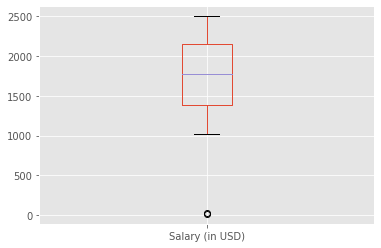

In [ ]:
# Generate a Boxplot
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

Παρατηρήστε το μικρό κύκλο στο κάτω μέρος του boxplot. Αποκτούμε αμέσως μια αίσθηση για ακραία τιμή εκεί καθώς αποκλίνει σε μεγάλο βαθμό από τα υπόλοιπα δεδομένα. 

Με το ιστόγραμμα κοιτάμε τα δεδομένα από άλλη οπτική οπτική γωνία

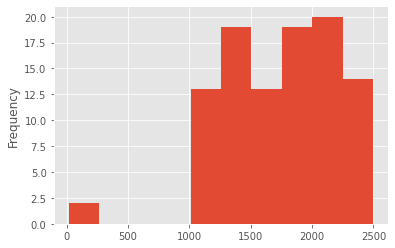

In [ ]:
# Generate a Histogram plot
salary_df['Salary (in USD)'].plot(kind='hist')
plt.show()

Στο παραπάνω γράφημα ιστογράμματος, μπορούμε επίσης να δούμε ότι υπάρχει ένα συγκεκριμένο δοχείο που δεν είναι σωστός καθώς αποκλίνει σε μεγάλο βαθμό από τα υπόλοιπα δεδομένα. 
Μπορούμε επίσης να συμπεράνουμε ότι υπάρχουν μόνο δύο υπάλληλοι για τους οποίους οι μισθοί φαίνεται να είναι στρεβλωμένοι (δείτε τον άξονα y).

Λοιπόν, ποιος μπορεί να είναι ένας άμεσος τρόπος επιβεβαίωσης ότι το σύνολο δεδομένων περιέχει ακραία αημεία; 

Ας ρίξουμε μια ματιά στις ελάχιστες και μέγιστες τιμές της στήλης Μισθός (σε USD).

In [ ]:
# Minimum and maximum salaries
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 17
Maximum salary 2498


Ο ελάχιστο μισθός ξέρουμε ότι είναι 100 USD αλλά ανακαλύψαμε κάτι διαφορετικό. Ως εκ τούτου, αξίζει να συμπεράνουμε ότι αυτό είναι πράγματι μια ακραία τιμή.

Σημείωση: Αυτές οι μικρές απεικονίσεις γίνονται συνήθως σε όσα χαρακτηριστικά του dataset θεωρούμε ότι μπορεί να περιέχουν ακραίες τιμές.(το συγκεκριμένο dataset έχει 1 τέτοιου είδους χαρακτηριστικό)

## Ανίχνευση με μεθόδους που βασίζονται στην ομαδοποίηση

Σε αυτήν την προσέγγιση, ξεκινάμε ομαδοποιώντας τα παρόμοια είδη αντικειμένων. H ομοιότητα μπορεί να μετρηθεί με την Euclidean, Manhatan απόσταση και ούτω καθεξής. 

Διασκορπισμένη πλοκή μερικών σημείων ένα 2D-επίπεδο
Θα χρησιμοποιήσουμε την ομαδοποίηση K-Means που θα μας βοηθήσει να συγκεντρώσουμε τα σημεία δεδομένων (αξίες μισθού στην περίπτωσή μας). Η εφαρμογή που πρόκειται να χρησιμοποιήσουμε για το KMeans χρησιμοποιεί εσωτερική απόσταση Euclidean. Ας αρχίσουμε.

Θα χρησιμοποιήσουμε το K-Means clustering που θα μας βοηθήσει να ομαδοποιήσουμε τα σημεία δεδομένων (μισθοί στην περίπτωσή μας). Η εφαρμογή που πρόκειται να χρησιμοποιήσουμε για το KMeans χρησιμοποιεί εσωτερική απόσταση Euclidean..

In [ ]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values

# For compatibility with the SciPy implementation
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')

Τώρα θα εισαγάγουμε τη μονάδα kmeans από το scipy.cluster.vq. 
Στη συνέχεια, θα εφαρμόσουμε kmeans στο salary_raw.



In [ ]:
# Import kmeans from SciPy
from scipy.cluster.vq import kmeans
    
# Specify the data and the number of clusters to kmeans()
centroids, avg_distance = kmeans(salary_raw, 4)


Εισάγουμε τους μισθούς στο kmeans() και προσδιορίσαμε επίσης τον αριθμό των συστάδων στις οποίες θέλουμε να ομαδοποιήσουμε τα σημεία των δεδομένων μας.
Στο centroids επιστρέφει τα κέντρα των συστάδων που δημιουργούνται από kmeans() και η avg_distance είναι η μέση απόσταση Ευκλείδειας μεταξύ των σημείων των δεδομένων μας και των κέντρων που δημιουργούνται από kmeans().

Ας αντιστοιχίσουμε τις ομάδες των σημείων δεδομένων καλώντας τη μέθοδο vq (). που δέχεται ως ορίσματα τα σημεία δεδομένων και το centroid όπως δημιουργείται από τον αλγόριθμο ομαδοποίησης (kmeans() στην περίπτωσή μας)
Στη συνέχεια επιστρέφει τις ομάδες (ομάδες) των σημείων δεδομένων και τις αποστάσεις μεταξύ των σημείων δεδομένων και των πλησιέστερων ομάδων.

In [ ]:
from scipy.cluster.vq import vq

# Get the groups (clusters) and distances
groups, cdist = vq(salary_raw, centroids)

Ας σχεδιάσουμε τώρα τις ομάδες που έχουμε.

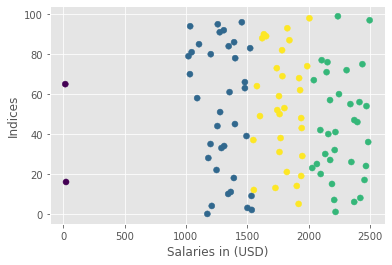

In [ ]:
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

Μπορούμε τώρα να επισημάνουμεε τα ακραία σημείας 

Προτού, λοιπόν, προσαρμόσετε τα δεδομένα σε ένα μοντέλο μηχανικής μάθησης θα πρέπει να έχετε άνει τα εξής:

Διερευνήστε διεξοδικά τα δεδομένα - ρίξτε μια ματιά σε κάθε ένα από τα χαρακτηριστικά που περιέχει το σύνολο δεδομένων και δώστε ιδιαίτερη προσοχή στα συνοπτικά στατιστικά τους, όπως μέσος όρος, διάμεσος.

* Η δημιουργία μιας σειράς χρήσιμων διαγραμμάτων των διαφορετικών χαρακτηριστικών του συνόλου δεδομένων θα σας επισημάνει την παρουσία των ακραίων τιμών που μπορεί να χρειαστούν περαιτέρω έρευνα.

* Δείτε πώς συσχετίζονται τα χαρακτηριστικά μεταξύ τους. Αυτό θα σας βοηθήσει να επιλέξετε τις πιο σημαντικές δυνατότητες από το σύνολο δεδομένων και να απορρίψετε τα περιττά.


## Μέθοδοι βασισμένες σε ταξινόμηση

Η παραπάνω μέθοδος για ανίχνευση ακραίων σημείων είναι καθαρά χωρίς επίβλεψη. Εάν είχαμε τις ετικέτες κλάσεων των σημείων δεδομένων, θα μπορούσαμε εύκολα να το μετατρέψουμε σε εποπτευόμενο πρόβλημα, συγκεκριμένα ένα πρόβλημα ταξινόμησης. 

Για να μπορέσουμε να αντιμετωπίσουμε την ανίχνευσης ακραίων σημείων ως ταξινόμησης, χρειαζόμαστε ένα σύνολο δεδομένων με ετικέτα. 
Ας δώσουμε στο υπάρχον σύνολο δεδομένων μας μερικές ετικέτες. 
Αρχικά θα εκχωρήσουμε όλες τις καταχωρήσεις στην τάξη του 0 και μετά θα επεξεργαστούμε χειροκίνητα τις ετικέτες τα αποδόσουμε ακραία σημεία. 
Θα διατηρήσουμε αυτές τις ετικέτες τάξης σε μια στήλη που ονομάζεται class. 
Η ετικέτα για τα ακραία σημεία θα είναι 1 (και για τις φυσιολογικές καταχωρίσεις οι ετικέτες θα είναι 0).

In [ ]:
# First assign all the instances to 
salary_df['class'] = 0

# Manually edit the labels for the anomalies
salary_df.at[16, 'class'] = 1
salary_df.at[65, 'class'] = 1

# Verify 
print(salary_df.loc[16])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
class                                  1
Name: 16, dtype: object


In [ ]:
salary_df.head()

,Person,Salary (in USD),class
0,Jason Brown,1175,0
1,Jacob Stein,2220,0
2,Cody Brown,1537,0
3,Larry Morales,1502,0
4,Jessica Hendricks,1211,0


Έχουμε τώρα μια εργασία δυαδικής ταξινόμησης. Θα χρησιμοποιήσουμε την ανίχνευση ακραίων τιμών με βάση την εγγύτητα.

Η βασική ιδέα εδώ είναι ότι η εγγύτητα ενός ακραίου σημείου δεδομένων στα πλησιέστερα γειτονικά σημεία δεδομένων αποκλίνει σε μεγάλο βαθμό από την εγγύτητα του σημείου δεδομένων στα περισσότερα από τα άλλα σημεία δεδομένων στο σύνολο δεδομένων.

Θα χρησιμοποιήσουμε τη μέθοδο ταξινόμησης k-NN για αυτό. Επίσης, πρόκειται να χρησιμοποιήσουμε μια βιβλιοθήκη Python που ονομάζεται [PyOD](https://pyod.readthedocs.io/en/latest/), η οποία έχει αναπτυχθεί ειδικά για σκοπούς ανίχνευσης ακραίων σημείων.

In [ ]:
!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
#!pip install --pre pyod      # or include pre-release version for new features
# Importing KNN module from PyOD
from pyod.models.knn import KNN

Η στήλη Person δεν είναι καθόλου χρήσιμη για το μοντέλο, καθώς δεν είναι παρά ένα είδος αναγνωριστικού δεν θα την χρησιμοποιήσουμε ως δεδομένα εκπαίδευσης.

In [ ]:
# Segregate the salary values and the class labels 
X = salary_df['Salary (in USD)'].values.reshape(-1,1)
y = salary_df['class'].values

# Train kNN detector
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X)

KNN(algorithm='auto', contamination=0.02, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Ο kNN παίρνειδύο παραμέτρους 
* contamination - το ποσό των ακραίων σημείων στα δεδομένα (σε ποσοστό) που για την περίπτωσή μας είναι 2/100 = 0,02
* n_neighbors - αριθμός γειτόνων που πρέπει να ληφθούν υπόψη για τη μέτρηση της εγγύτητας

Ας πάρουμε τώρα τις ετικέτες πρόβλεψης στα δεδομένα προπόνησης και στη συνέχεια λάβουμε τις τελικές βαθμολογίες των δεδομένων εκπαίδευσης. 
Όσο υψηλότερες είναι οι βαθμολογίες, τόσο πιο πολλά ακραία σημεία έχει το dataset.

In [ ]:
# Get the prediction labels of the training data
y_train_pred = clf.labels_ 
    
# Outlier scores
y_train_scores = clf.decision_scores_

Ας προσπαθήσουμε τώρα να αξιολογήσουμε το KNN () σε σχέση με τα δεδομένα εκπαίδευσης. Το PyOD παρέχει μια εύχρηστη λειτουργία για αυτό - evaluate_print( )

In [ ]:
# Import the utility function for model evaluation
from pyod.utils import evaluate_print

# Evaluate on the training data
evaluate_print('KNN', y, y_train_scores)

KNN ROC:1.0, precision @ rank n:1.0


Βλέπουμε ότι το μοντέλο KNN () μπόρεσε να αποδώσει εξαιρετικά καλά στα δεδομένα εκπαίδευσης. Παρέχει τρεις μετρήσεις και τις βαθμολογίες τους:ROC, ακρίβεια και βαθμός εμπιστοσύνης.
Σημείωση: Ενώ εντοπίζουμε ακραία σημεία, σχεδόν πάντα χρησιμοποιούμε το ROC και το Precision καθώς δίνει πολύ καλύτερη ιδέα για την απόδοση του μοντέλου. 

Δεν έχουμε δεδομένα δοκιμής αλλά μπορούμε όμως να δημιουργήσουμε ένα δείγμα μισθού.



In [ ]:
# A salary of $37 (an anomaly right?)
X_test = np.array([[37.]])

Ας δοκιμάσουμε τώρα αν το μοντέλο θα μπορέσει να ανιχνεύσει αυτήν την μισθολογική αξία ως ακραίο σημείο ή όχι.

In [ ]:
# Check what the model predicts on the given test data point
clf.predict(X_test)

array([1])

Η έξοδος πρέπει να είναι: array ([1])

Ας δούμε επίσης πώς λειτουργεί το μοντέλο σε ένα "φυσιολογικό" σημείο δεδομένων.Μπορούμε να δούμε τι προβλέπει ακριβώς το μοντέλο. 

In [ ]:
# A salary of $1256
X_test_abnormal = np.array([[1256.]])

# Predict
clf.predict(X_test_abnormal)

array([0])



Και η έξοδος:array([0])

Το μοντέλο προέβλεψε αυτό ως το "φυσιολογικό"σημείο δεδομένων που είναι σωστό. 

# Παράδειγμα σύγκρισης όλων των μοντέλων ανίχνευσης Outlier


Το PyOD είναι μια ολοκληρωμένη εργαλειοθήκη Python για τον εντοπισμό ακραίων αντικειμένων σε δεδομένα πολλαπλών χαρακτηριστικών με μη εποπτευόμενες και εποπτευόμενες μεθόδους. Το μοντέλο που καλύπτεται σε αυτό το παράδειγμα περιλαμβάνει:

Γραμμικά μοντέλα για ανίχνευση Outlier:

* PCA: Principal Component Analysis use the sum of weighted projected distances to the eigenvector hyperplane as the outlier outlier scores)
* MCD: Minimum Covariance Determinant (use the mahalanobis distances as the outlier scores)
* OCSVM: One-Class Support Vector Machines
* Proximity-Based Outlier Detection Models:
* LOF: Local Outlier Factor
* CBLOF: Clustering-Based Local Outlier Factor
* kNN: k Nearest Neighbors (use the distance to the kth nearest neighbor as the outlier score)
* Median kNN Outlier Detection (use the median distance to k nearest neighbors as the outlier score)
* HBOS: Histogram-based Outlier Score
* Probabilistic Models for Outlier Detection:
* ABOD: Angle-Based Outlier Detection
* Outlier Ensembles and Combination Frameworks
* Isolation Forest
* Feature Bagging
* LSCP

In [ ]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

In [ ]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [ ]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

In [ ]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)


1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
10 fitting One-class SVM (OCSVM)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)


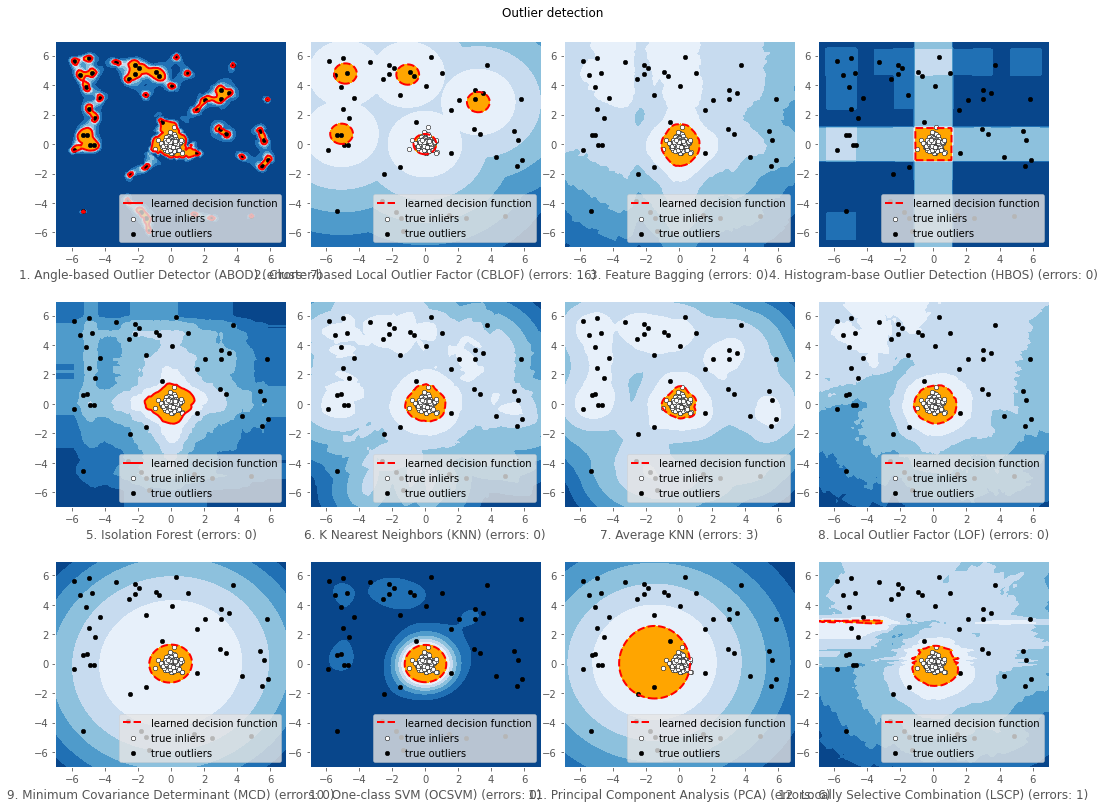

In [ ]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()